## DWT LSTM model

* Sliding window
* All annotations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os, sys
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import soundfile as sf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import librosa.display
import librosa
import torch
import scipy.signal as sps
import resampy

repo_base_directory = os.path.dirname(os.getcwd())
sys.path.append(repo_base_directory)
from annotation_utils import discretize_all

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# ########################## PARAMETER DEFINITION ##########################

#  ************************* Annotation parameters *************************
combined_annotations_filepath = 'compiled_annotations_df.parquet'
# combined_annotations_filepath = 'sample.parquet'
audio_directory = '/content/drive/MyDrive/data-audio'
SEGMENT_LENGTH = 2.5
HOP_LENGTH = 0.5
OVERLAP_THRESH = 0.5

#  ************************ Augmentation parameters ************************
N_AUGMENT_PER_CHUNK = 1
SHUFFLE_SEED = 0
SR = 22050 # Desired sample rate (if native sampling rate is different, will be resampled with resampy)

#  ************************* Spectrogram parameters ************************
# See: https://stackoverflow.com/questions/62584184/understanding-the-shape-of-spectrograms-and-n-mels
# Number of mel-frequency bands in mel-spectrogram
MEL_BINS = 50
# Lowest and highest frequency (in Hz) to include in mel-scale
F_MIN = 0
F_MAX = 8000 # SR // 2

# FFT_SIZE determines frequency resolution of the window
# in speech processing, the recommended value is 512, corresponding to 23 milliseconds at SR of 22050 Hz
# at SR of 44100, this equals 1024; see https://librosa.org/doc/main/generated/librosa.stft.html#librosa.stft
FFT_SIZE = 1024
FFT_HOP_LENGTH = FFT_SIZE // 4
# Construct matrix to warp linear scale spectrogram to mel scale
MEL_FILTERBANK = tf.signal.linear_to_mel_weight_matrix(num_mel_bins = MEL_BINS,
                                                       num_spectrogram_bins = FFT_SIZE // 2 + 1,
                                                       sample_rate = SR,
                                                       lower_edge_hertz = F_MIN,
                                                       upper_edge_hertz = F_MAX)

In [4]:
def episode_id_to_audio(ep_id, ep_data, audio_directory):
    episode_filepath = os.path.join(audio_directory, ep_id + ep_data['filetype'])
    # fast: if prioritizing speed (over memory)
    if ep_data['filetype'] == '.ogg': #.ogg read is faster in soundfile
        audio, sr = sf.read(episode_filepath)
        audio = np.mean(audio, axis=1)
    elif ep_data['filetype'] == '.mp3': 
        #.mp3 not supported in soundfile, use audioread instead, used in backend of librosa:
        # https://librosa.org/doc/main/_modules/librosa/core/audio.html#load
        audio, sr = librosa.core.audio.__audioread_load(episode_filepath,
                                                        offset = 0, duration = None, dtype=np.float32)  
        audio = np.mean(audio, axis=0)
    if sr != SR:
        audio = resampy.resample(audio, sr, SR)
    return audio, SR

def episode_audio_to_audio_chunks(audio, audio_duration, segment_length, hop_length):
    audio_chunks =  []
    start_times = np.arange(0, audio_duration - segment_length, hop_length)
    for s in start_times:
        start_sample = librosa.time_to_samples(s, sr = SR)
        end_sample = librosa.time_to_samples(s + segment_length, sr = SR)
        sub_audio = audio[start_sample:end_sample]
        audio_chunks.append(sub_audio)
    audio_chunks = np.vstack(audio_chunks)
    #audio_chunks = pad_sequences(audio_chunks, value = 0, padding = 'post')
    return audio_chunks

def discretized_dict_to_dataset(discretized_dict, audio_directory, segment_length, hop_length):
    labels = []
    audio_chunks = []
    ep_ids = []; id2ep = {}; sample_rates = []
    prints = [] # store print statements, so print all episode durations at once 
    
    for idx, ep_id in enumerate(tqdm(discretized_dict)):
        ep_data = discretized_dict[ep_id]
        audio_duration = ep_data['audio_duration']
        ep_audio, ep_sr = episode_id_to_audio(ep_id, ep_data, audio_directory)
        ep_audio_chunks = episode_audio_to_audio_chunks(ep_audio, audio_duration, 
                                                        segment_length, hop_length)
        labels.append(ep_data['y'])
        audio_chunks.append(ep_audio_chunks)
        ep_ids.extend([idx] * len(ep_audio_chunks))
        id2ep[idx] = ep_id
        sample_rates.append(ep_sr)
        prints.append(f"{ep_id} duration: {(len(ep_audio)/ep_sr)/60:.2f} mins \n")
    labels = np.hstack(labels).reshape(-1,1)
    audio_chunks = np.vstack(audio_chunks)
    ep_ids = np.hstack(ep_ids).reshape(-1,1)
    print(f"Sample rates found: {np.unique(sample_rates)}")
    for p in prints:
        print(p)
    return audio_chunks, labels, ep_ids, id2ep

def chunks_and_labels_to_dataset(audio_chunks, labels):
    audio_ds = tf.data.Dataset.from_tensor_slices(audio_chunks)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

def audio_chunk_to_spectrogram(audio_chunk, mel_filterbank, frame_length, frame_step, sr = SR):
    '''
    References: 
    * https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06
    * https://gist.github.com/keunwoochoi/c9592922a17d71b745d47dc8eb7f0538
    '''
    # Cast waveform to float32
    audio_chunk = tf.cast(audio_chunk, dtype=tf.float32)
    # Convert waveform to spectrogram via STFT, and obtain magnitude
    spectrograms = tf.signal.stft(audio_chunk, frame_length = frame_length, frame_step = frame_step)
    magnitude_spectrograms = tf.abs(spectrograms)
    mel_spectrograms = tf.matmul(tf.square(magnitude_spectrograms), mel_filterbank)
    # Add channels axis:
    mel_spectrograms = mel_spectrograms[..., tf.newaxis]
    return mel_spectrograms

def audio_batch_augmentor(audio_batch, torch_augmentor, sr = SR):
    '''Augmentor that works on batches at train time'''
    original_shape = audio_batch.shape
    audio_batch = tf.expand_dims(audio_batch, axis = 1).numpy()
    batch_aug = torch_augmentor(samples = torch.Tensor(audio_batch).detach(), sample_rate = sr)
    batch_aug = tf.convert_to_tensor(batch_aug.squeeze().numpy())
    batch_aug.set_shape(original_shape)
    print(original_shape)
    return batch_aug

In [5]:
hottake_list = ['1jfWVd1sTapjjkQwDM4yQX',
                '0pIwpmg5oPcMWJXVSyrx4E', 
                '2DCEgkjSeRQyMt8KovG8vF',
                '7LxbgPH3grqf6lCpLKEwo7',
                '7vxD3WNDRkigLnIDHyy0cu',
                '7r367wUYs1EvyBbeyOcq39',
                '0TkGYYIPwRqx8xzP0XGvRG']
hot_take = ['0pIwpmg5oPcMWJXVSyrx4E.parquet',
            '7vxD3WNDRkigLnIDHyy0cu.parquet',
           '7r367wUYs1EvyBbeyOcq39.parquet',
           '7LxbgPH3grqf6lCpLKEwo7.parquet',
           '0TkGYYIPwRqx8xzP0XGvRG.parquet',
           '2DCEgkjSeRQyMt8KovG8vF.parquet']
compiled_annotations_df = pd.read_parquet(combined_annotations_filepath)
new_df = compiled_annotations_df.loc[compiled_annotations_df['text'].isin(hottake_list)]
new_df.to_parquet('sample.parquet')

In [6]:
%%capture
_, discretized_dict = discretize_all(combined_annotations_filepath, 
                                     audio_filepath = audio_directory,
                                     segment_length = SEGMENT_LENGTH, 
                                     hop_length = HOP_LENGTH, 
                                     overlap_thresh = OVERLAP_THRESH)
discretized_dict = discretized_dict['data']

all_ep_ids = list(discretized_dict.keys())
# train_ep_ids = [i for i in all_ep_ids if i != '1XgTQnRlfJ0zpDdg2DccbR']
# test_ep_ids = ['1XgTQnRlfJ0zpDdg2DccbR'] #australian
train_ep_ids = ['1jfWVd1sTapjjkQwDM4yQX', 
                '2DCEgkjSeRQyMt8KovG8vF',
                '7LxbgPH3grqf6lCpLKEwo7',
                '7vxD3WNDRkigLnIDHyy0cu',
                '0TkGYYIPwRqx8xzP0XGvRG']

test_ep_ids = ['0pIwpmg5oPcMWJXVSyrx4E','7r367wUYs1EvyBbeyOcq39'
              #,'1XgTQnRlfJ0zpDdg2DccbR'
              ]

train_dict = { ep_id: discretized_dict[ep_id] for ep_id in train_ep_ids }
test_dict = { ep_id: discretized_dict[ep_id] for ep_id in test_ep_ids }

In [ ]:
discretized_dict.keys()

dict_keys(['6hoNS9LR1Lxb4EzMX72kXR', '79aiOALBohH9vEIUHPAoRj', '0pIwpmg5oPcMWJXVSyrx4E', '7LxbgPH3grqf6lCpLKEwo7', '7vxD3WNDRkigLnIDHyy0cu', '7r367wUYs1EvyBbeyOcq39', '0TkGYYIPwRqx8xzP0XGvRG', '1XgTQnRlfJ0zpDdg2DccbR', '2hgBlERSFYDWndqjWNOV6v', '1jfWVd1sTapjjkQwDM4yQX', '2DCEgkjSeRQyMt8KovG8vF'])

In [7]:
if os.path.exists('train.npy'):
    with open('train.npy', 'rb') as f:
        train_audio_chunks = np.load(f)
        train_labels = np.load(f)
        train_ep_ids = np.load(f)
else:
    print("Loading train from raw audio...")
    train_audio_chunks, train_labels, train_ep_ids, train_id2ep = discretized_dict_to_dataset(train_dict,
                                                                                              audio_directory,
                                                                                              SEGMENT_LENGTH, 
                                                                                              HOP_LENGTH)
    with open('train.npy', 'wb') as f:
        np.save(f, train_audio_chunks)
        np.save(f, train_labels)
        np.save(f, train_ep_ids)
if os.path.exists('test.npy'):
    with open('test.npy', 'rb') as f:
        test_audio_chunks = np.load(f)
        test_labels = np.load(f)
        test_ep_ids = np.load(f)
else:
    print("Loading test from raw audio...")
    test_audio_chunks, test_labels, test_ep_ids, test_id2ep = discretized_dict_to_dataset(test_dict,
                                                                                          audio_directory,
                                                                                          SEGMENT_LENGTH,
                                                                                          HOP_LENGTH)
    with open('test.npy', 'wb') as f:
        np.save(f, test_audio_chunks)
        np.save(f, test_labels)
        np.save(f, test_ep_ids)

Loading train from raw audio...


100%|██████████| 5/5 [02:39<00:00, 31.88s/it]


Sample rates found: [22050]
1jfWVd1sTapjjkQwDM4yQX duration: 5.95 mins 

2DCEgkjSeRQyMt8KovG8vF duration: 6.98 mins 

7LxbgPH3grqf6lCpLKEwo7 duration: 6.91 mins 

7vxD3WNDRkigLnIDHyy0cu duration: 7.76 mins 

0TkGYYIPwRqx8xzP0XGvRG duration: 25.12 mins 

Loading test from raw audio...


100%|██████████| 2/2 [00:49<00:00, 24.77s/it]


Sample rates found: [22050]
0pIwpmg5oPcMWJXVSyrx4E duration: 8.25 mins 

7r367wUYs1EvyBbeyOcq39 duration: 7.68 mins 



In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
with tf.device('/cpu:0'):
    # High batch size is important for imbalanced classes
    BATCH_SIZE = 32
    X_train, X_val, y_train, y_val = train_test_split(train_audio_chunks, train_labels, 
                                                      test_size = 0.2,
                                                      #stratify = np.hstack([train_ep_ids, train_labels]),
                                                      #shuffle = True,
                                                      random_state = 46)

    X_test, y_test = test_audio_chunks, test_labels

    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")

    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")

    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")

    train_ds = chunks_and_labels_to_dataset(X_train, y_train)
    train_ds = train_ds.batch(BATCH_SIZE)

    val_ds = chunks_and_labels_to_dataset(X_val, y_val)
    val_ds = val_ds.batch(BATCH_SIZE)


X_train: (5043, 55125)
y_train: (5043, 1)
X_val: (1261, 55125)
y_val: (1261, 1)
X_test: (1902, 55125)
y_test: (1902, 1)


In [10]:
X_train_lstm = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_val_lstm = X_val.reshape(X_val.shape[0],1,X_val.shape[1])

In [11]:
X_val_lstm

array([[[ 5.89601123e-02,  7.50580847e-02,  4.43507942e-02, ...,
          3.24792283e-02,  3.56079712e-02,  1.57976491e-02]],

       [[-4.30066793e-04, -3.59862660e-04, -4.49669851e-04, ...,
         -4.30713751e-03, -3.85383280e-03, -3.67192425e-03]],

       [[-9.00224724e-02, -8.70727002e-02, -8.23945931e-02, ...,
         -2.38217649e-01, -2.43135351e-01, -2.46086007e-01]],

       ...,

       [[-1.07723017e-02, -8.23710292e-03, -3.24836894e-03, ...,
         -1.36312646e-02,  1.38503169e-02,  9.84489431e-03]],

       [[-9.56013220e-04, -1.99557276e-04, -2.56289247e-03, ...,
          1.66881490e-02,  2.20008181e-02,  2.75003350e-02]],

       [[ 2.15445591e-03,  7.38589421e-04,  7.74351819e-05, ...,
         -1.53149357e-01, -1.05795869e-01, -1.29043649e-02]]])

In [12]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve

# split a multivariate sequence into samples
n_steps = 5
EPOCHS = 30
metrics = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'prc', curve = 'PR')]

In [13]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(1, X_train.shape[1]))))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
# fit model
history = model.fit(X_train_lstm, y_train, epochs=EPOCHS, verbose=0)

In [14]:
yhat = model.predict(X_test.reshape(X_test.shape[0],1,X_test.shape[1]), verbose=0)

In [15]:
yhat

array([[1.1306114e-06],
       [7.0265983e-03],
       [1.4865710e-09],
       ...,
       [9.6267264e-08],
       [1.2997890e-01],
       [1.4516036e-01]], dtype=float32)

In [16]:
yhat_pred = np.where(yhat>0.5, 1, 0).flatten()
#print(yhat_pred)

In [17]:
print(classification_report(y_test, yhat_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1831
           1       0.07      0.15      0.09        71

    accuracy                           0.89      1902
   macro avg       0.52      0.53      0.52      1902
weighted avg       0.93      0.89      0.91      1902



In [18]:
print(confusion_matrix(y_test, yhat_pred))

[[1673  158]
 [  60   11]]


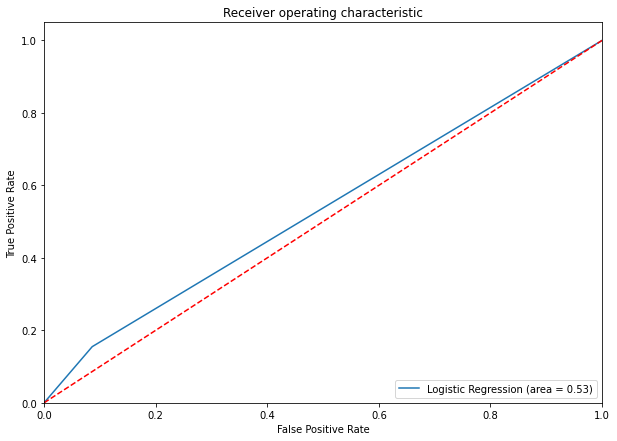

In [19]:
logit_roc_auc = roc_auc_score(y_test, yhat_pred)
fpr, tpr, thresholds = roc_curve(y_test, yhat_pred)
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='LSTM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()